In [6]:
import salem
import xarray as xr
from utils import constants as cnst
from utils import u_plot as uplot, u_darrays as uda, u_met
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde, linregress
import ipdb

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [12]:
tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(8,10), longitude=slice(40,43))

In [15]:
#topof = '/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km.nc'
topof = '/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_combined_POSTac144_ancil_4km.nc'
ds = xr.open_dataset(topof, decode_times=False).squeeze()  #half gridlength correction for pixels
#regrid = griddata_lin(ds['ht'].values[0:-1,0:-1], ds.rlon[0:-1]-(ds.rlon[1::].values-ds.rlon[0:-1].values)/2, ds.rlat[0:-1]-(ds.rlat[1::].values-ds.rlat[0:-1].values)/2, tdiff.longitude, tdiff.latitude)
regrid = griddata_lin(ds['ht'].values, ds.rlon, ds.rlat, tdiff.longitude, tdiff.latitude)
new_topo =  xr.DataArray(regrid, coords={'latitude':  tdiff.latitude.values, 'longitude': tdiff.longitude.values},dims=['latitude', 'longitude'])
new_topo.to_netcdf('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_combined_POSTac144_ancil_4km_REGRIDDED_noshift.nc')

In [11]:
def griddata_lin(data, x, y, new_x, new_y):

    """
    :param x: current x variables (1 or 2d, definitely 2d if irregular!)
    :param y: current y variables (1 or 2d, definitely 2d if irregular!)
    :param new_x: target x vars
    :param new_y: target y vars
    :return:  triangulisation lookup table, point weights, 2d shape - inputs for interpolation func
    """

    if x.ndim == 1:
        grid_xs, grid_ys = np.meshgrid(x, y)
    else:
        grid_xs = x
        grid_ys = y

    if new_x.ndim == 1:
        new_xs, new_ys = np.meshgrid(new_x, new_y)
    else:
        new_xs = new_x
        new_ys = new_y

    points = np.array((grid_xs.flatten(), grid_ys.flatten())).T
    inter = np.array((np.ravel(new_xs), np.ravel(new_ys))).T
    shape = new_xs.shape

    # Interpolate using delaunay triangularization
    data = griddata(points, data.flatten(), inter, method='linear')
    data = data.reshape((shape[0], shape[1]))

    return data

In [39]:
def var2_binning_perc(xvar, yvar, xbins):
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['y'] = []
    outdic['ycount'] = []
    outdic['ystd'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        mask = (xvar > shl-100) & (xvar <= shl+100)

        #outdic['y'].append(np.nanmean(yvar[mask]))
        #print(shl)

        try:
            #outdic['y'].append(np.percentile(yvar[mask],95))
            #outdic['y'].append(np.median(yvar[mask]))
            #ipdb.set_trace()
            outdic['y'].append(np.percentile(yvar[mask],90))
            outdic['ystd'].append(np.std(yvar[mask]))
            outdic['ycount'].append(np.sum(np.isfinite(yvar[mask])))
            #ipdb.set_trace()

        except:
            # outdic['y'].append(np.nan)
            # outdic['ystd'].append(np.nan)
            # outdic['ycount'].append(np.nan)

            outdic['y'].append(0)
            outdic['ystd'].append(0)
            outdic['ycount'].append(0)

        #ipdb.set_trace()

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic

In [44]:
def var2_binning_mean(xvar, yvar, xbins):
    """
    :param xvar: xvar of the 2dhist
    :param yvar: yvar of the 2d hist
    :param xbins: bins to use for the xvar
    :param ybins: bins to use for the yvar
    :param varlist: dictionary of variables to put into histogram
    :param varpick: list of variables in dic to calculate
    :return:
    """
    outdic = {}
    outdic['y'] = []
    outdic['ycount'] = []
    outdic['ystd'] = []


    for issh, shl in enumerate(xbins[0:-1]):

        mask = (xvar > shl-100) & (xvar <= shl+100)

        #outdic['y'].append(np.nanmean(yvar[mask]))
        #print(shl)

        try:
            #outdic['y'].append(np.percentile(yvar[mask],95))
            #outdic['y'].append(np.median(yvar[mask]))
            #ipdb.set_trace()
            outdic['y'].append(np.mean(yvar[mask]))
            outdic['ystd'].append(np.std(yvar[mask]))
            outdic['ycount'].append(np.sum(np.isfinite(yvar[mask])))
            #ipdb.set_trace()

        except:
            # outdic['y'].append(np.nan)
            # outdic['ystd'].append(np.nan)
            # outdic['ycount'].append(np.nan)

            outdic['y'].append(0)
            outdic['ystd'].append(0)
            outdic['ycount'].append(0)

        #ipdb.set_trace()

    outdic['xbins'] = (np.round(xbins[0:-1]+((xbins[1::]-xbins[0:-1])/2),2))


    return outdic


[63873, 104228, 140199, 147146, 155895, 157021, 157162, 151849, 132846, 111097, 91866, 74399, 64005, 55312, 46740, 38902, 31965, 25467, 21118, 17756, 14681, 12472, 10657, 9072, 8181, 7512, 6768, 6121, 5416, 4846, 4394, 3992, 3732, 3380, 3104, 2912, 2525, 2229, 1923, 1578, 1343, 1098, 904, 748, 610, 519, 427, 358, 323, 258, 226, 200, 163, 146, 122, 108, 97, 84, 70, 56, 40, 32, 28, 26, 25, 24, 18]


<ErrorbarContainer object of 3 artists>

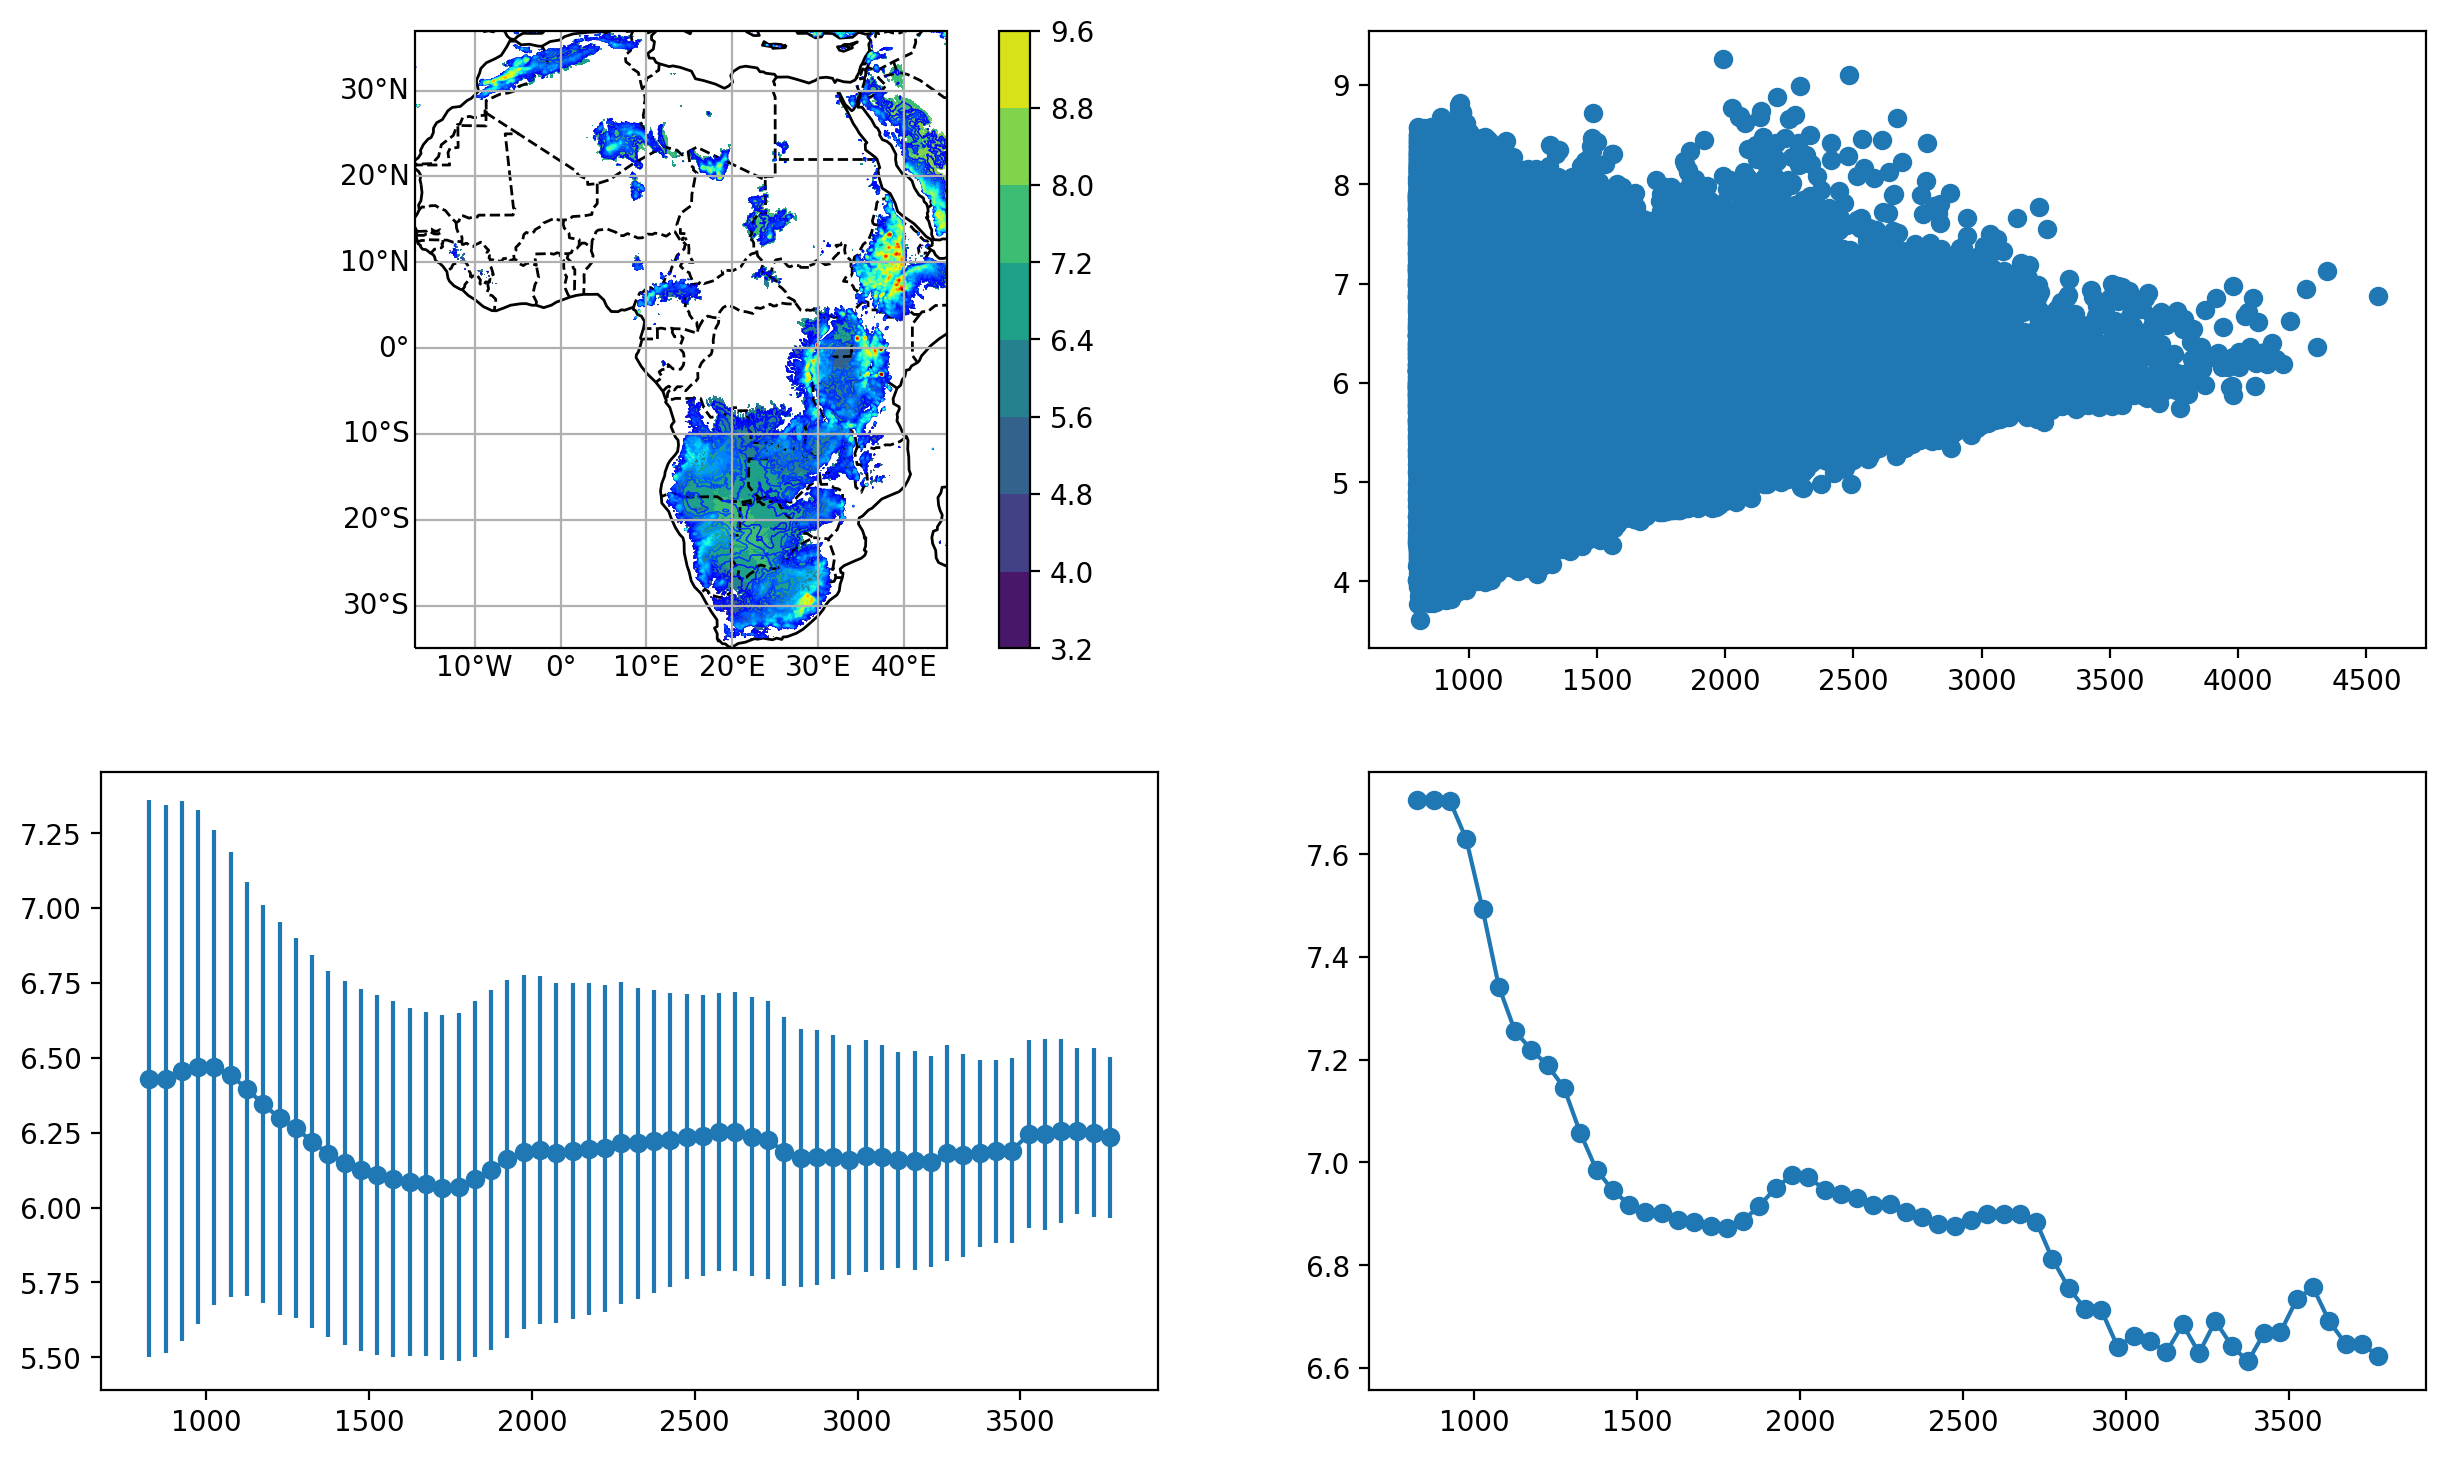

In [73]:
#tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(0,35), longitude=slice(-17,45))

northern = [-17,45,4,14]
southern = [27,43,-35,20]
alls = [-17,45,-35,37]
h = 800

box = alls

tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_diff.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = xr.open_dataarray('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km_REGRIDDED.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = new_topo.where(new_topo>800)
tdiff = tdiff.where(new_topo>800)


f = plt.figure(figsize=(15,9), dpi=200)


ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
t=new_topo
tt=tdiff['t2_daily']
mapp = ax.contourf(t.longitude, t.latitude, tt, transform=ccrs.PlateCarree())
plt.colorbar(mapp)
mapp = ax.contour(t.longitude, t.latitude, t, transform=ccrs.PlateCarree(), levels=np.arange(500,4200,100), linewidths=0.5, cmap='jet')
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
ax = f.add_subplot(2,2,2)

tnonan = tt.values.flatten()
tnonan = tnonan[np.isfinite(tnonan)]

toponan = t.values.flatten()
toponan = toponan[np.isfinite(toponan)]

ax.scatter(toponan,tnonan)

ax = f.add_subplot(2,2,3)

outdic = var2_binning_mean(toponan, tnonan, np.arange(800,4200,50))
outdicp = var2_binning_perc(toponan, tnonan, np.arange(800,4200,50))

ispos = np.where(np.array(outdic['ycount']) < 50)
print(outdic['ycount'])
y = np.array(outdic['y'])
y[ispos] = np.nan
ax.errorbar(outdic['xbins'],y, yerr=outdic['ystd'], linestyle=None, marker='o')


ax = f.add_subplot(2,2,4)
ispos = np.where(np.array(outdicp['ycount']) < 50)
y = np.array(outdicp['y'])
y[ispos] = np.nan
plt.errorbar(outdicp['xbins'],y, yerr=0, linestyle=None, marker='o')

#f.savefig('/home/ck/DIR/cornkle/figs/EDW/southern_hemisphere.jpg')

[17160, 24641, 29740, 25927, 22472, 19158, 17472, 15806, 13041, 10765, 8780, 6830, 5546, 4474, 3761, 3146, 2665, 2329, 1964, 1669, 1474, 1275, 1186, 1099, 942, 802, 691, 618, 575, 538, 487, 440, 380, 337, 297, 254, 213, 191, 154, 122, 102, 75, 66, 47, 38, 25, 16, 12, 9, 7, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<ErrorbarContainer object of 3 artists>

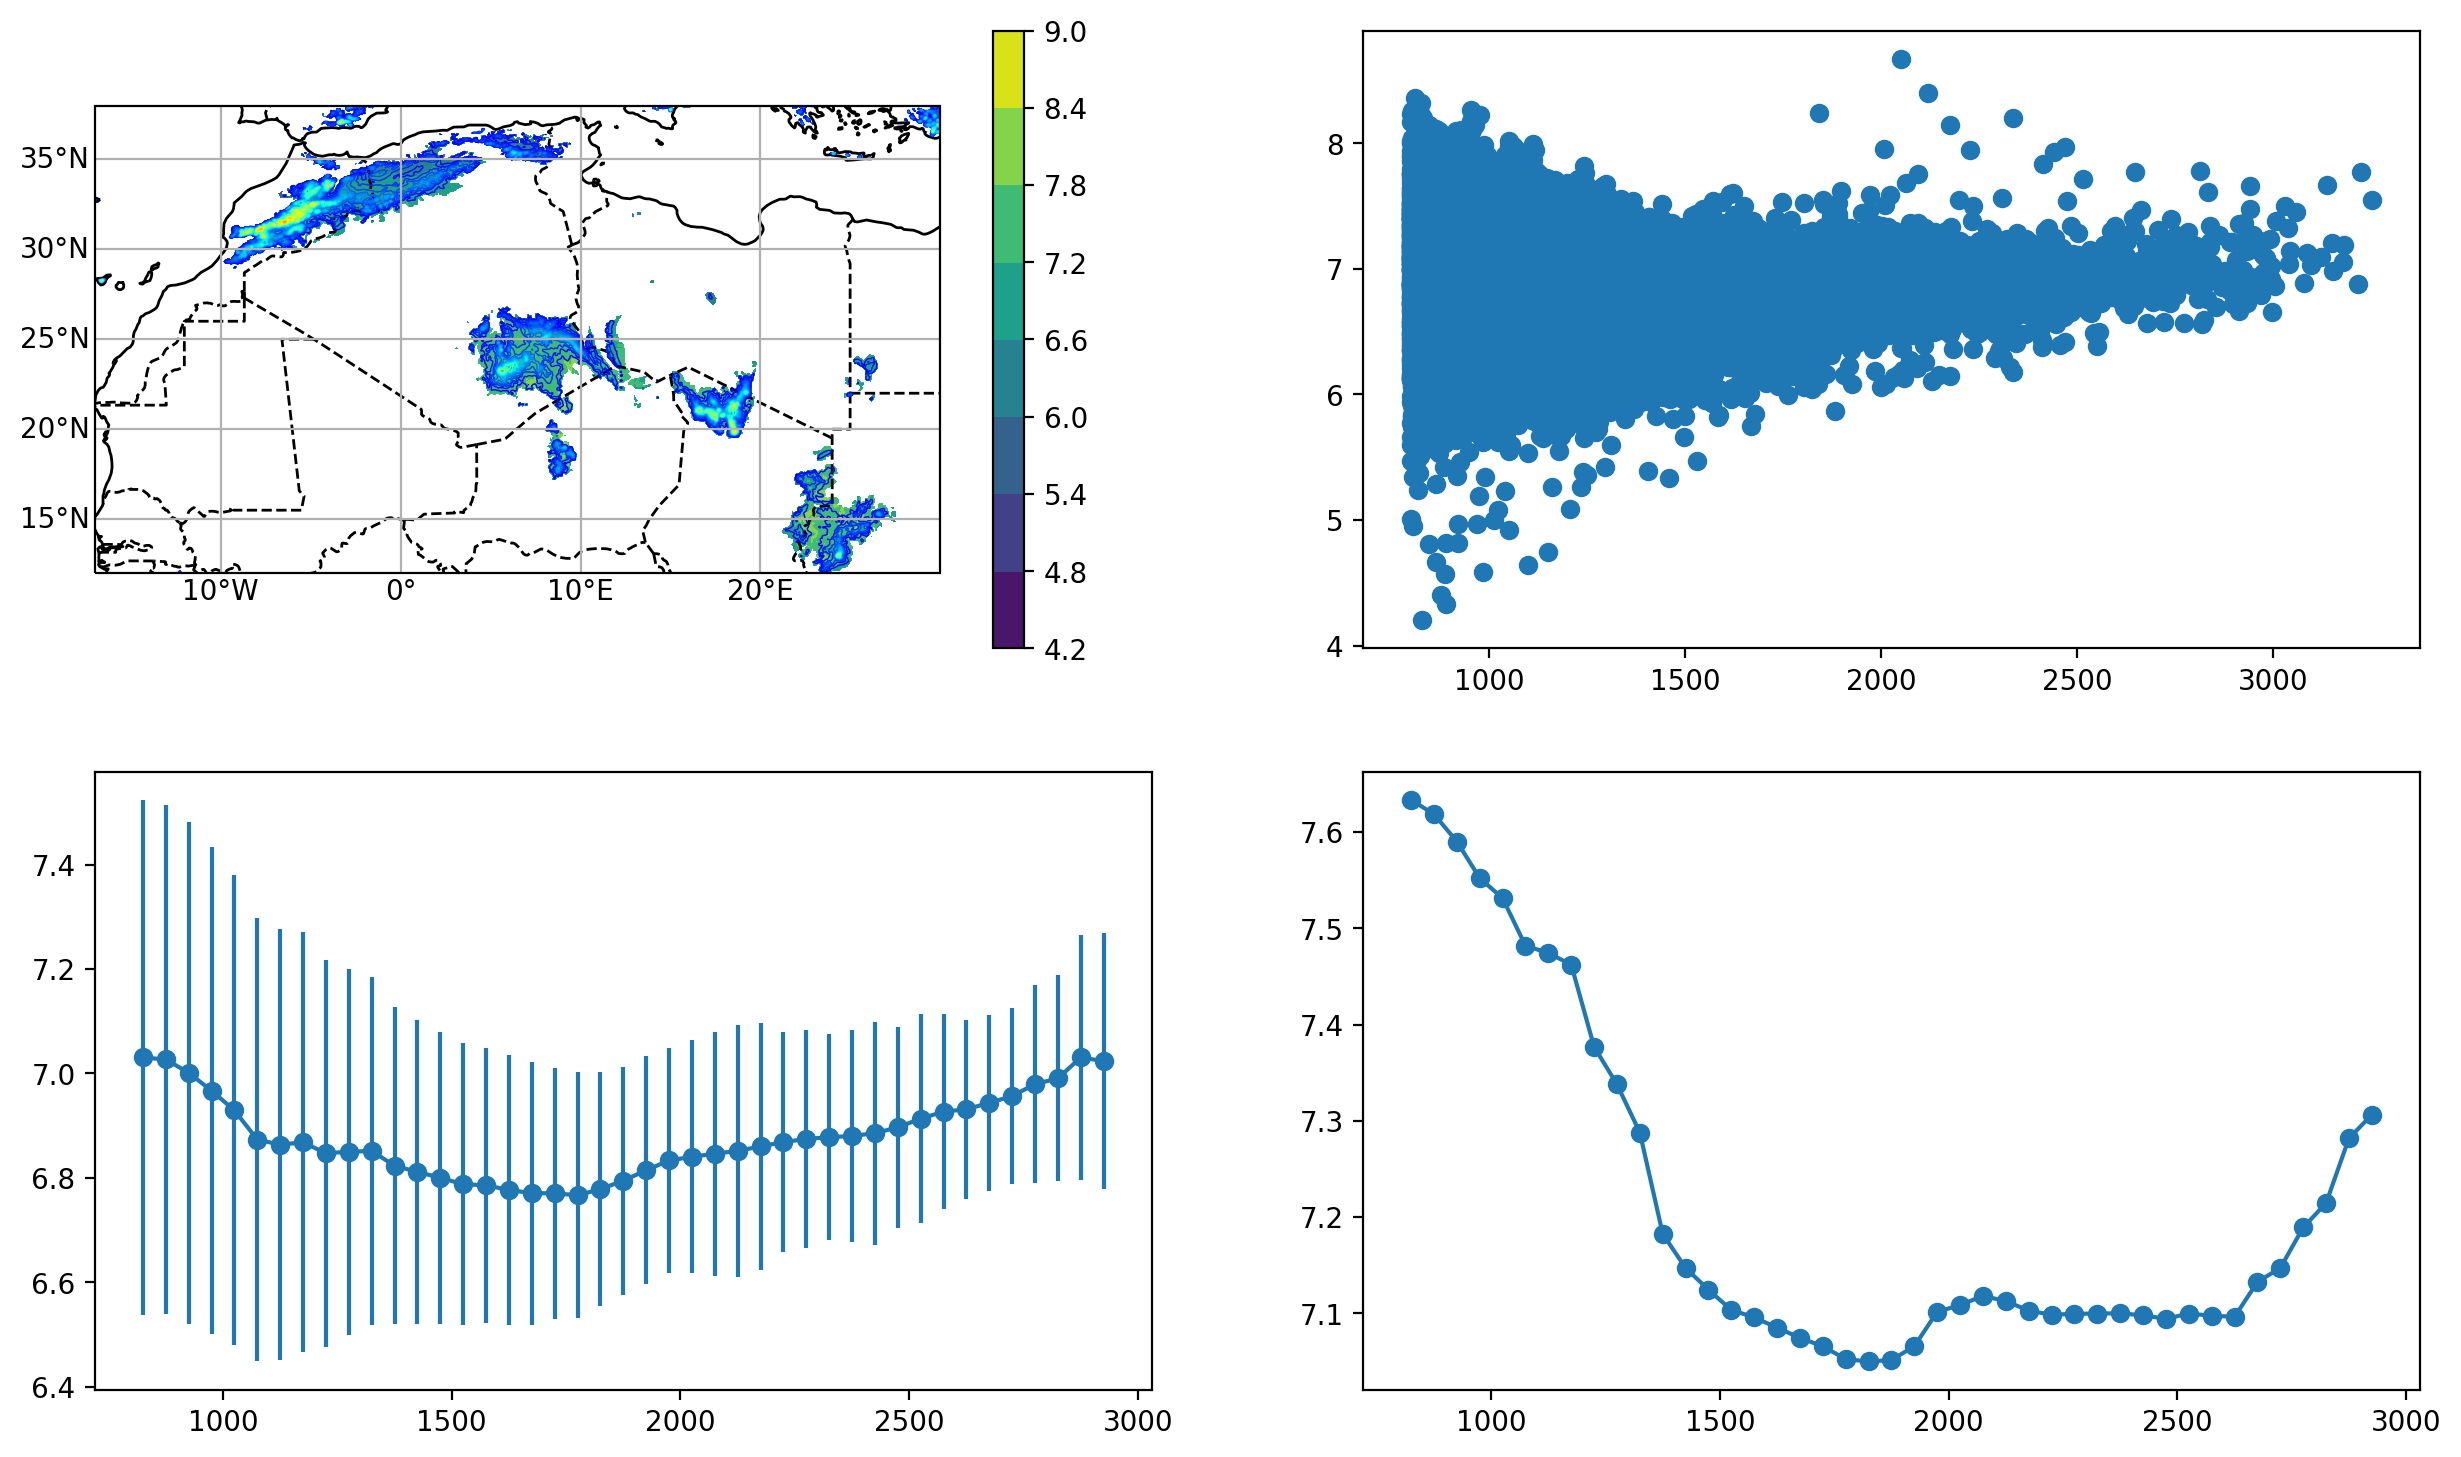

In [63]:
#tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(0,35), longitude=slice(-17,45))

northern = [-17,30,12,38]
southern = [27,43,-35,20]
alls = [-17,45,-35,37]
h = 800

box = northern

tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_diff.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = xr.open_dataarray('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km_REGRIDDED.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = new_topo.where(new_topo>800)
tdiff = tdiff.where(new_topo>800)


f = plt.figure(figsize=(15,9), dpi=200)


ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
t=new_topo
tt=tdiff['t2_daily']
mapp = ax.contourf(t.longitude, t.latitude, tt, transform=ccrs.PlateCarree())
plt.colorbar(mapp)
mapp = ax.contour(t.longitude, t.latitude, t, transform=ccrs.PlateCarree(), levels=np.arange(500,4200,100), linewidths=0.5, cmap='jet')
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
ax = f.add_subplot(2,2,2)

tnonan = tt.values.flatten()
tnonan = tnonan[np.isfinite(tnonan)]

toponan = t.values.flatten()
toponan = toponan[np.isfinite(toponan)]

ax.scatter(toponan,tnonan)

ax = f.add_subplot(2,2,3)

outdic = var2_binning_mean(toponan, tnonan, np.arange(800,4200,50))
outdicp = var2_binning_perc(toponan, tnonan, np.arange(800,4200,50))

ispos = np.where(np.array(outdic['ycount']) < 50)
print(outdic['ycount'])
y = np.array(outdic['y'])
y[ispos] = np.nan
ax.errorbar(outdic['xbins'],y, yerr=outdic['ystd'], linestyle=None, marker='o')


ax = f.add_subplot(2,2,4)
ispos = np.where(np.array(outdicp['ycount']) < 50)
y = np.array(outdicp['y'])
y[ispos] = np.nan
plt.errorbar(outdicp['xbins'],y, yerr=0, linestyle=None, marker='o')

#f.savefig('/home/ck/DIR/cornkle/figs/EDW/southern_hemisphere.jpg')

[9452, 13893, 16479, 13747, 11279, 8932, 8553, 8559, 8181, 7524, 6760, 5944, 5698, 5882, 5819, 5538, 5217, 4712, 4611, 4694, 4592, 4340, 3850, 3370, 3171, 3064, 2914, 2778, 2543, 2324, 2156, 1957, 1864, 1729, 1608, 1589, 1419, 1263, 1129, 929, 797, 674, 568, 474, 395, 352, 308, 276, 262, 215, 187, 161, 129, 117, 95, 82, 73, 59, 51, 41, 24, 20, 15, 13, 11, 11, 9]


<ErrorbarContainer object of 3 artists>

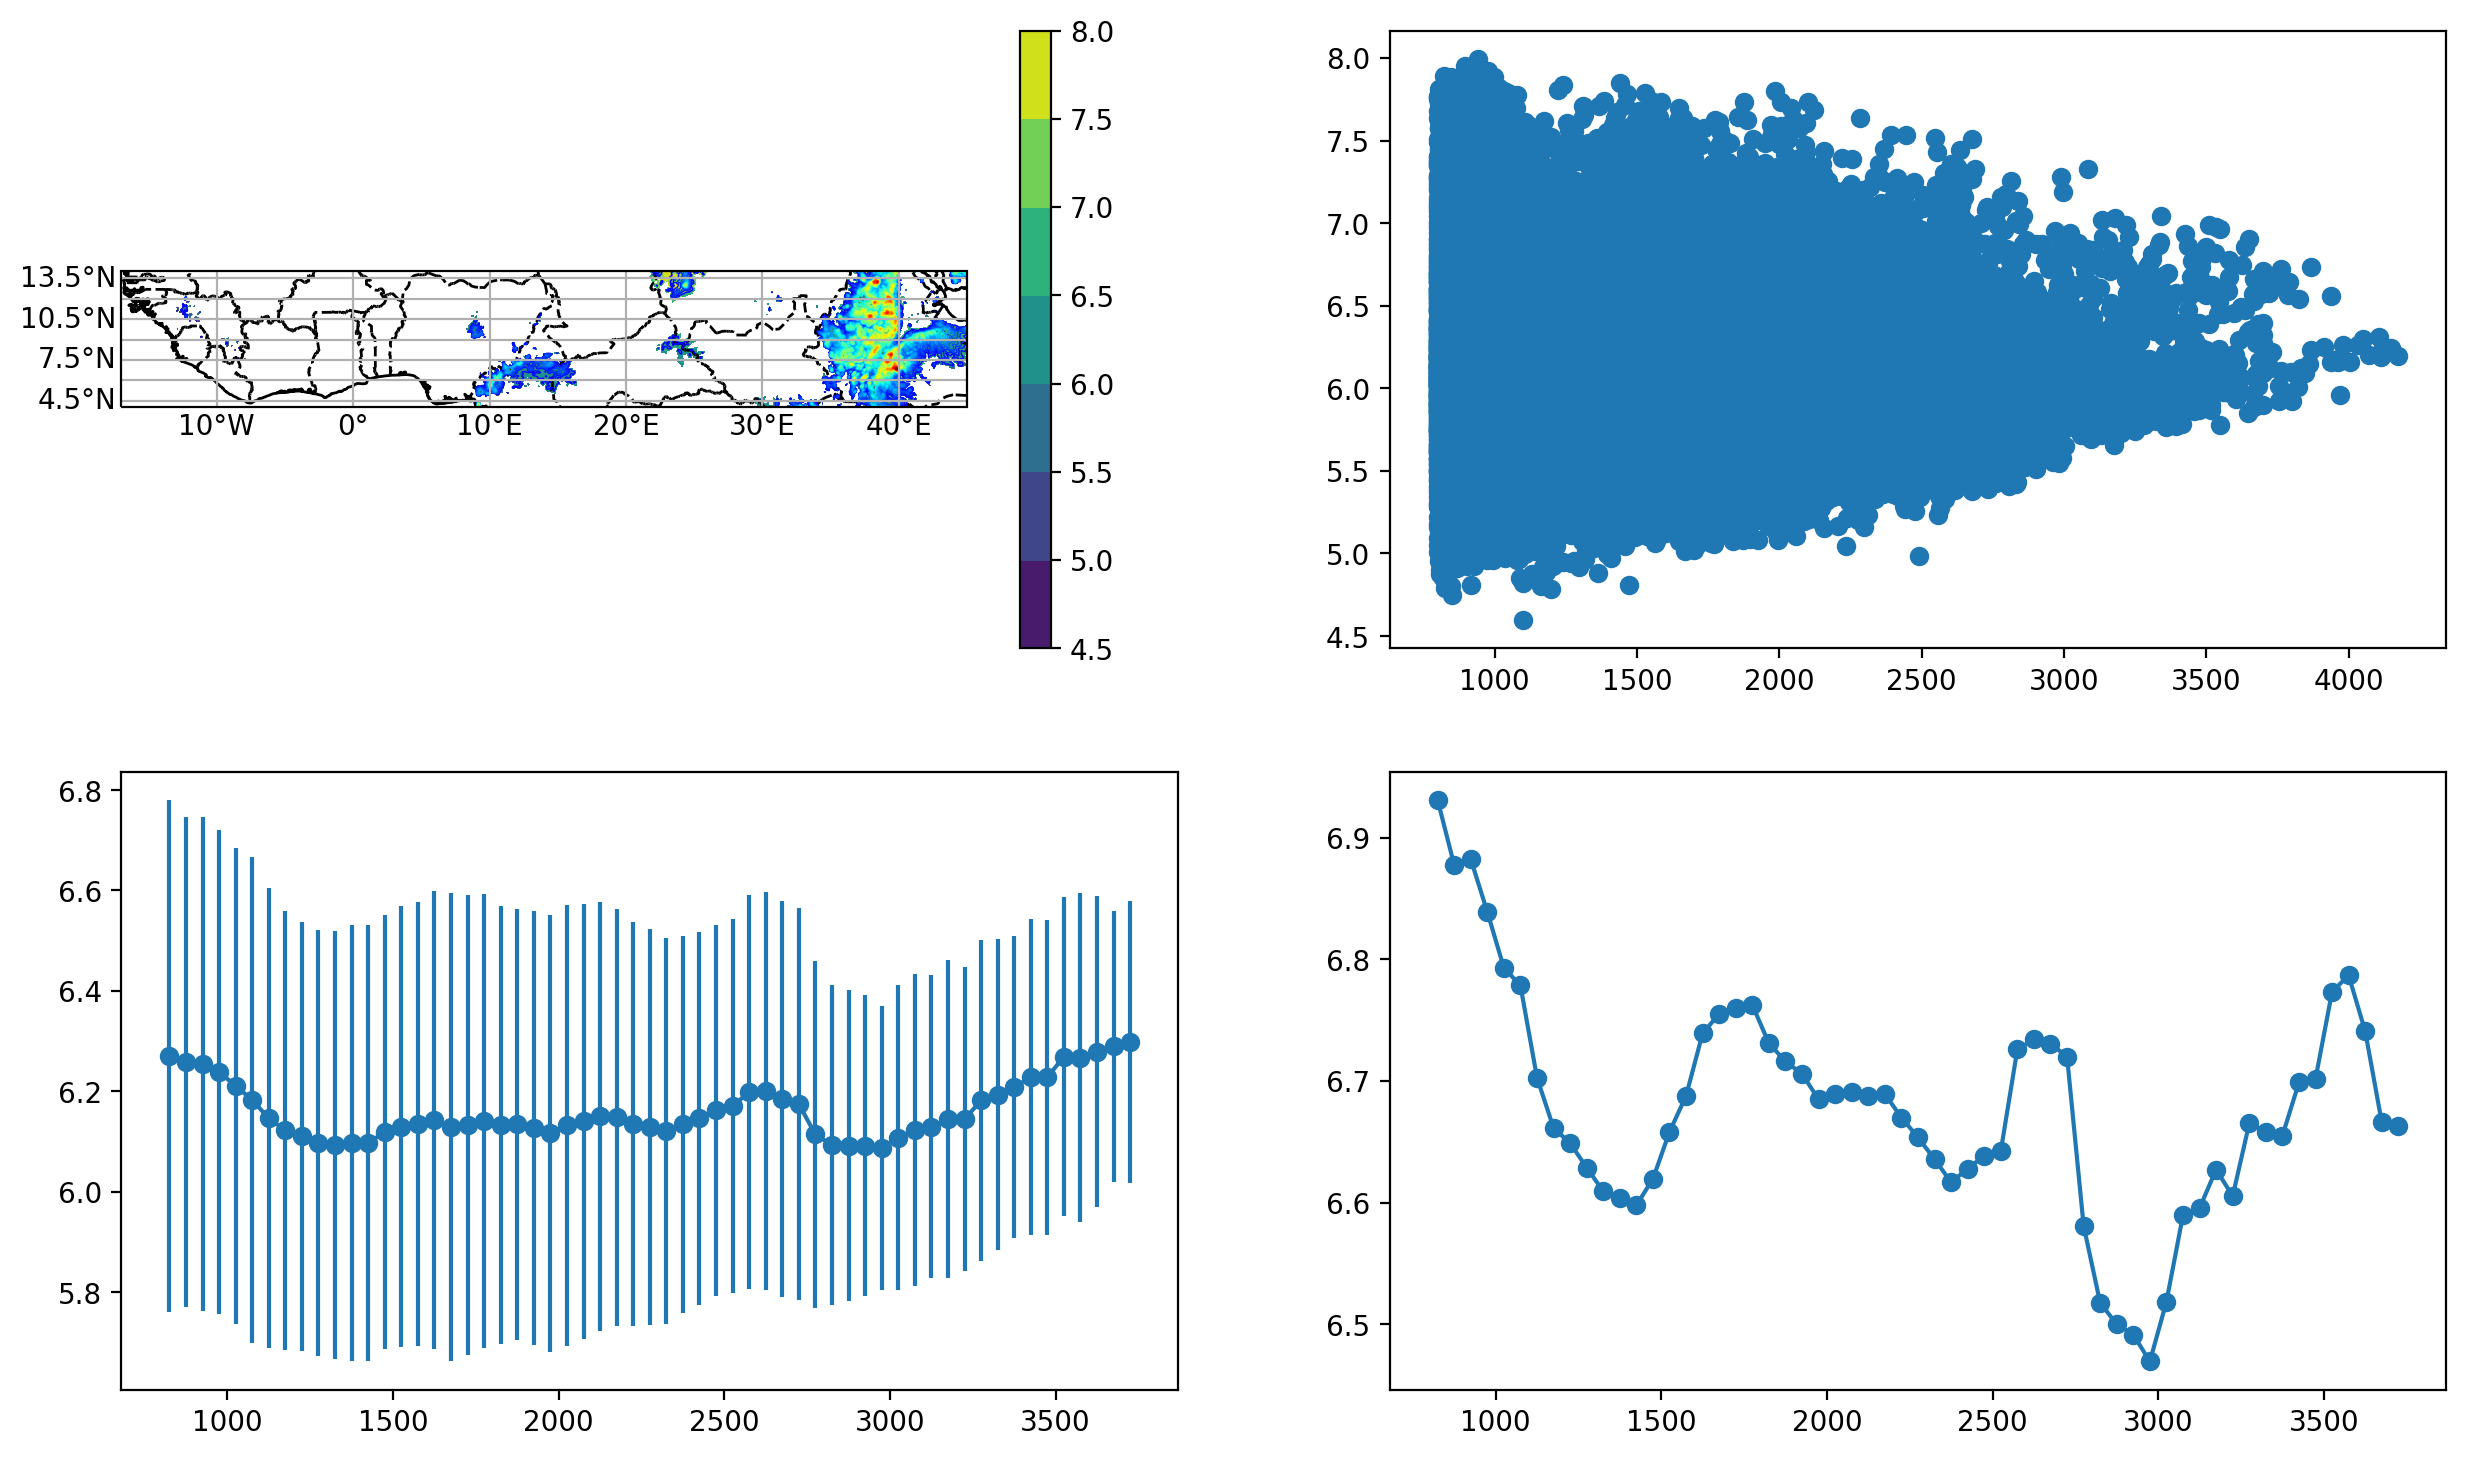

In [62]:
#tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(0,35), longitude=slice(-17,45))

northern = [-17,45,4,14]
southern = [27,43,-35,20]
alls = [-17,45,-35,37]
h = 800

box = northern

tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_diff.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = xr.open_dataarray('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km_REGRIDDED.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = new_topo.where(new_topo>800)
tdiff = tdiff.where(new_topo>800)


f = plt.figure(figsize=(15,9), dpi=200)


ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
t=new_topo
tt=tdiff['t2_daily']
mapp = ax.contourf(t.longitude, t.latitude, tt, transform=ccrs.PlateCarree())
plt.colorbar(mapp)
mapp = ax.contour(t.longitude, t.latitude, t, transform=ccrs.PlateCarree(), levels=np.arange(500,4200,100), linewidths=0.5, cmap='jet')
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
ax = f.add_subplot(2,2,2)

tnonan = tt.values.flatten()
tnonan = tnonan[np.isfinite(tnonan)]

toponan = t.values.flatten()
toponan = toponan[np.isfinite(toponan)]

ax.scatter(toponan,tnonan)

ax = f.add_subplot(2,2,3)

outdic = var2_binning_mean(toponan, tnonan, np.arange(800,4200,50))
outdicp = var2_binning_perc(toponan, tnonan, np.arange(800,4200,50))

ispos = np.where(np.array(outdic['ycount']) < 50)
print(outdic['ycount'])
y = np.array(outdic['y'])
y[ispos] = np.nan
ax.errorbar(outdic['xbins'],y, yerr=outdic['ystd'], linestyle=None, marker='o')


ax = f.add_subplot(2,2,4)
ispos = np.where(np.array(outdicp['ycount']) < 50)
y = np.array(outdicp['y'])
y[ispos] = np.nan
plt.errorbar(outdicp['xbins'],y, yerr=0, linestyle=None, marker='o')

#f.savefig('/home/ck/DIR/cornkle/figs/EDW/southern_hemisphere.jpg')

[7606, 13367, 16588, 16458, 16765, 20631, 27577, 34335, 36193, 31750, 25624, 19366, 16435, 14198, 11856, 9407, 7046, 4971, 4129, 3559, 3016, 2564, 2096, 1695, 1513, 1432, 1272, 1072, 882, 682, 572, 526, 498, 446, 427, 366, 311, 303, 258, 227, 195, 137, 97, 73, 53, 43, 34, 30, 25, 18, 20, 23, 22, 21, 20, 17, 14, 12, 7, 5, 6, 7, 7, 9, 11, 10, 8]


<ErrorbarContainer object of 3 artists>

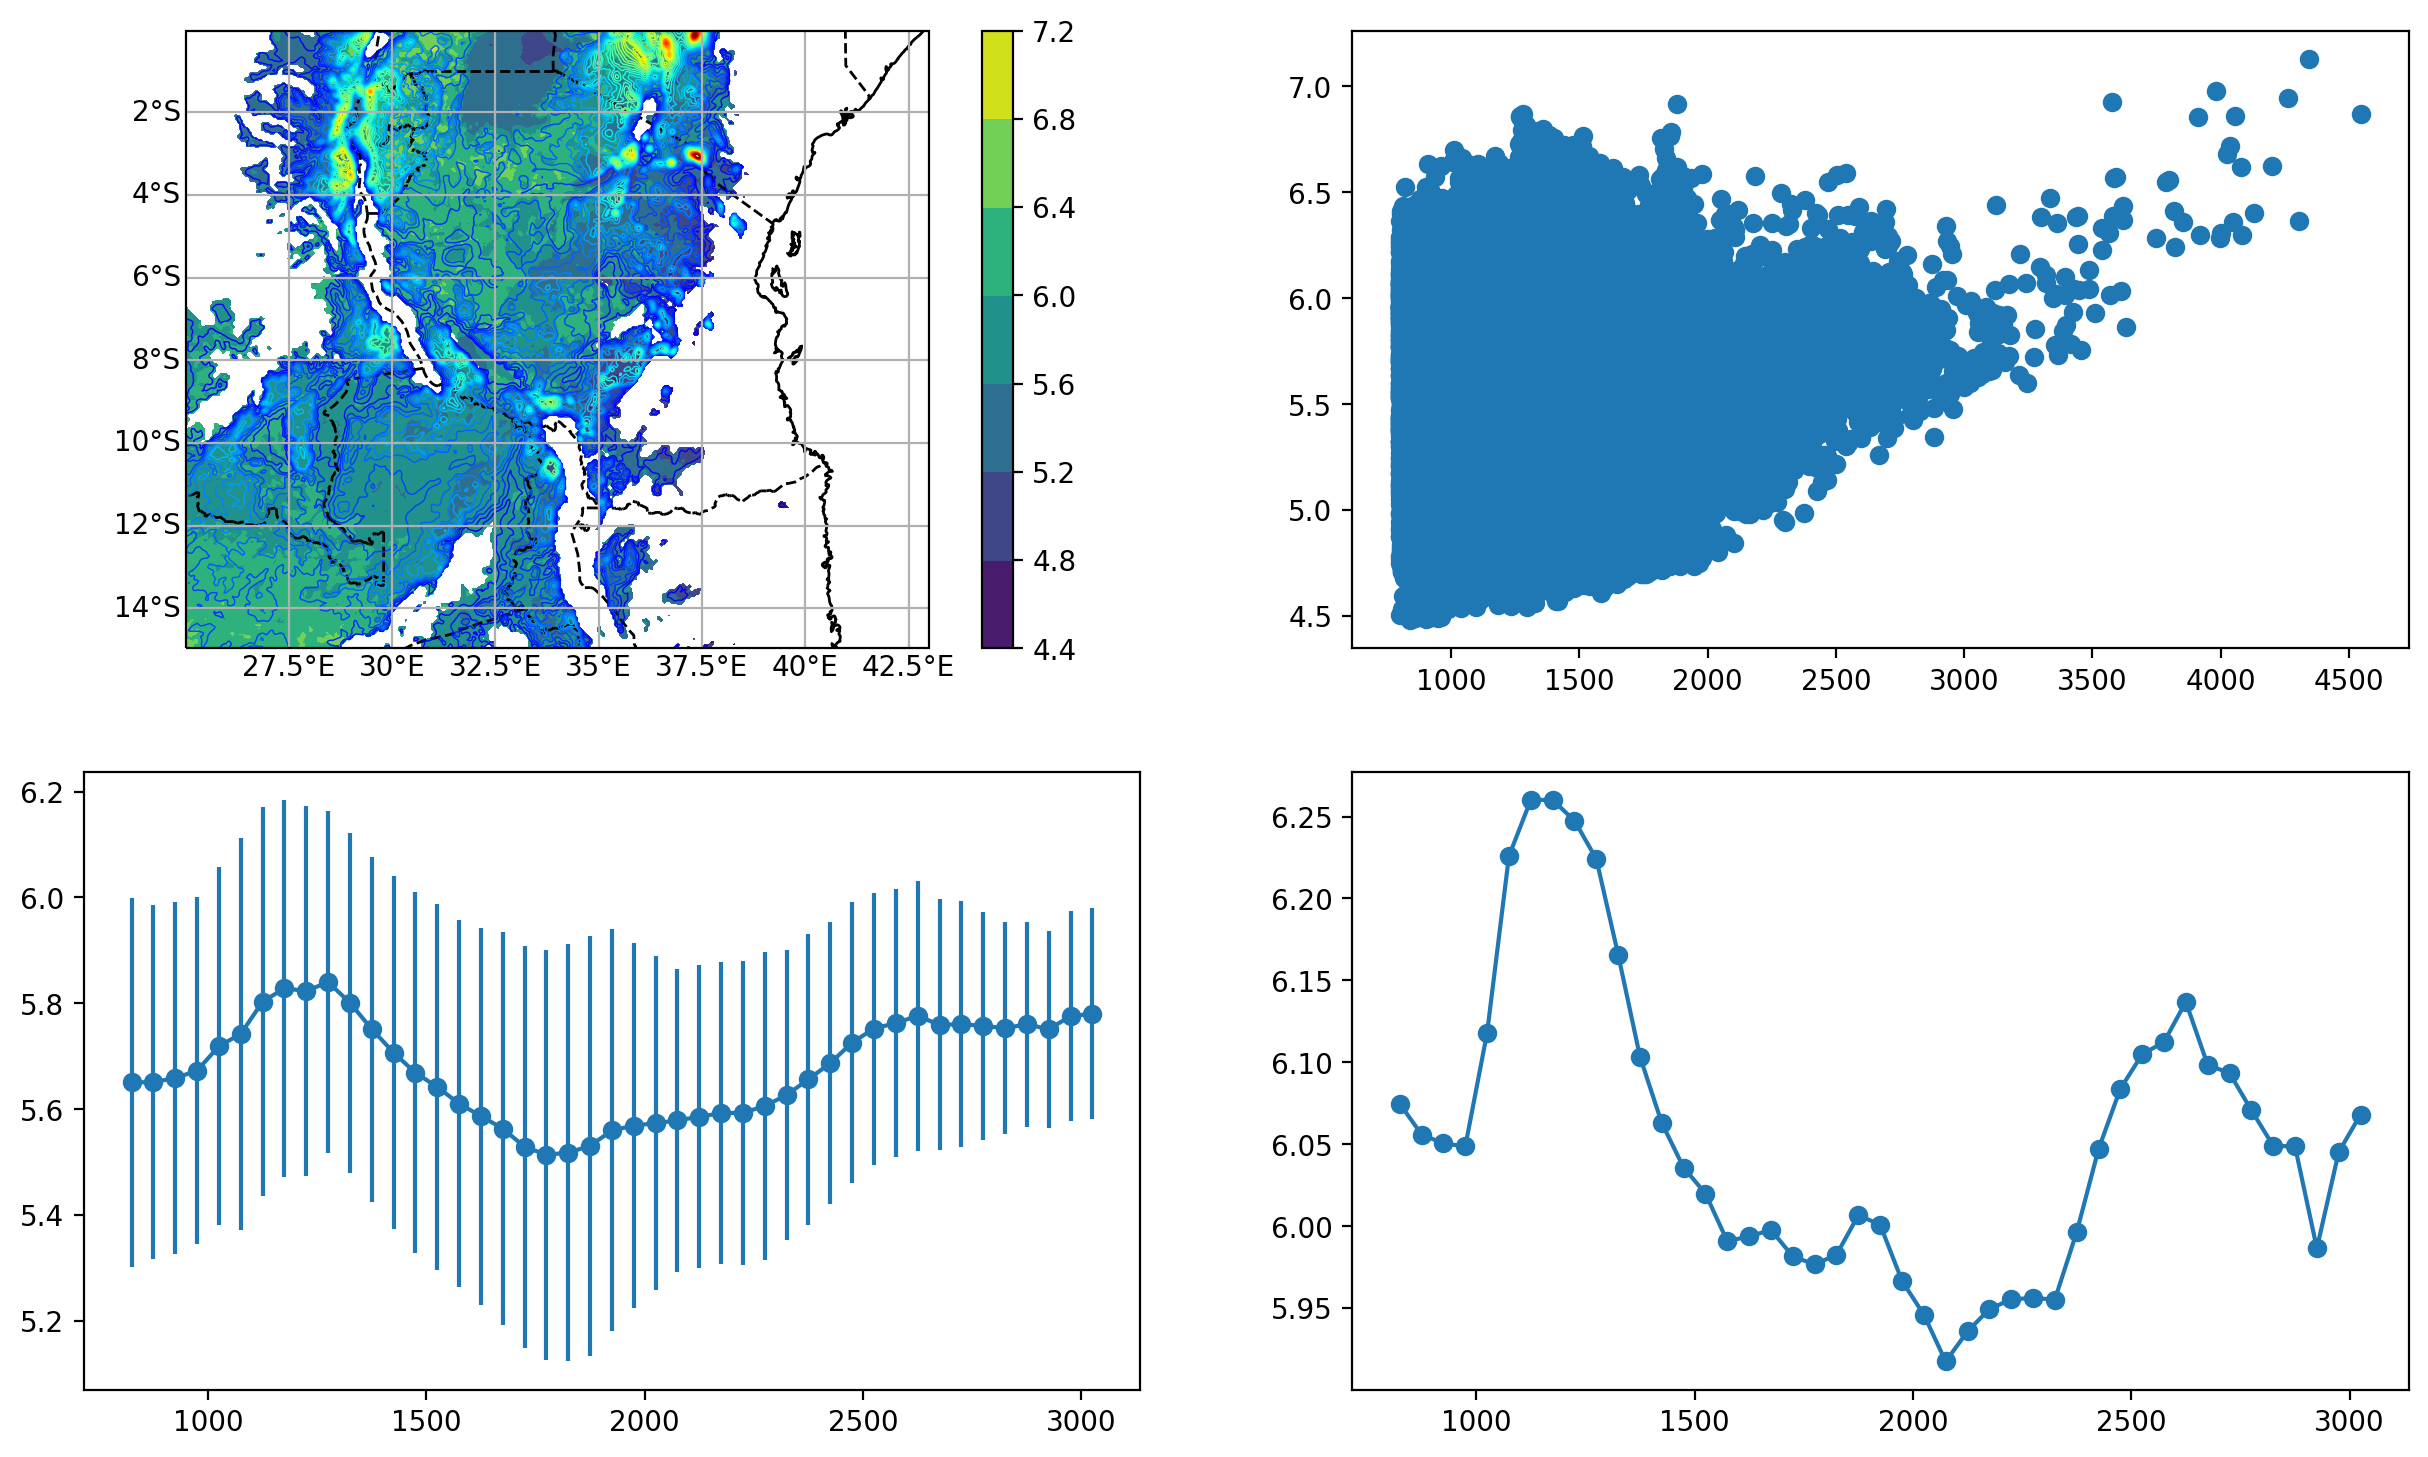

In [65]:
#tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(0,35), longitude=slice(-17,45))

northern = [-17,45,4,14]
southern = [25,43,-15,0]
alls = [-17,45,-35,37]
h = 800

box = southern

tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_diff.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = xr.open_dataarray('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km_REGRIDDED.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = new_topo.where(new_topo>800)
tdiff = tdiff.where(new_topo>800)


f = plt.figure(figsize=(15,9), dpi=200)


ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
t=new_topo
tt=tdiff['t2_daily']
mapp = ax.contourf(t.longitude, t.latitude, tt, transform=ccrs.PlateCarree())
plt.colorbar(mapp)
mapp = ax.contour(t.longitude, t.latitude, t, transform=ccrs.PlateCarree(), levels=np.arange(500,4200,100), linewidths=0.5, cmap='jet')
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
ax = f.add_subplot(2,2,2)

tnonan = tt.values.flatten()
tnonan = tnonan[np.isfinite(tnonan)]

toponan = t.values.flatten()
toponan = toponan[np.isfinite(toponan)]

ax.scatter(toponan,tnonan)

ax = f.add_subplot(2,2,3)

outdic = var2_binning_mean(toponan, tnonan, np.arange(800,4200,50))
outdicp = var2_binning_perc(toponan, tnonan, np.arange(800,4200,50))

ispos = np.where(np.array(outdic['ycount']) < 50)
print(outdic['ycount'])
y = np.array(outdic['y'])
y[ispos] = np.nan
ax.errorbar(outdic['xbins'],y, yerr=outdic['ystd'], linestyle=None, marker='o')


ax = f.add_subplot(2,2,4)
ispos = np.where(np.array(outdicp['ycount']) < 50)
y = np.array(outdicp['y'])
y[ispos] = np.nan
plt.errorbar(outdicp['xbins'],y, yerr=0, linestyle=None, marker='o')

#f.savefig('/home/ck/DIR/cornkle/figs/EDW/southern_hemisphere.jpg')

[5209, 9240, 13778, 17272, 19887, 19634, 18660, 16681, 14532, 13904, 13291, 12016, 10786, 9537, 8317, 7429, 6388, 5199, 3924, 2715, 1749, 1194, 887, 658, 537, 467, 398, 358, 322, 342, 346, 338, 343, 309, 298, 286, 250, 226, 201, 177, 161, 135, 112, 102, 81, 67, 44, 22, 11, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<ErrorbarContainer object of 3 artists>

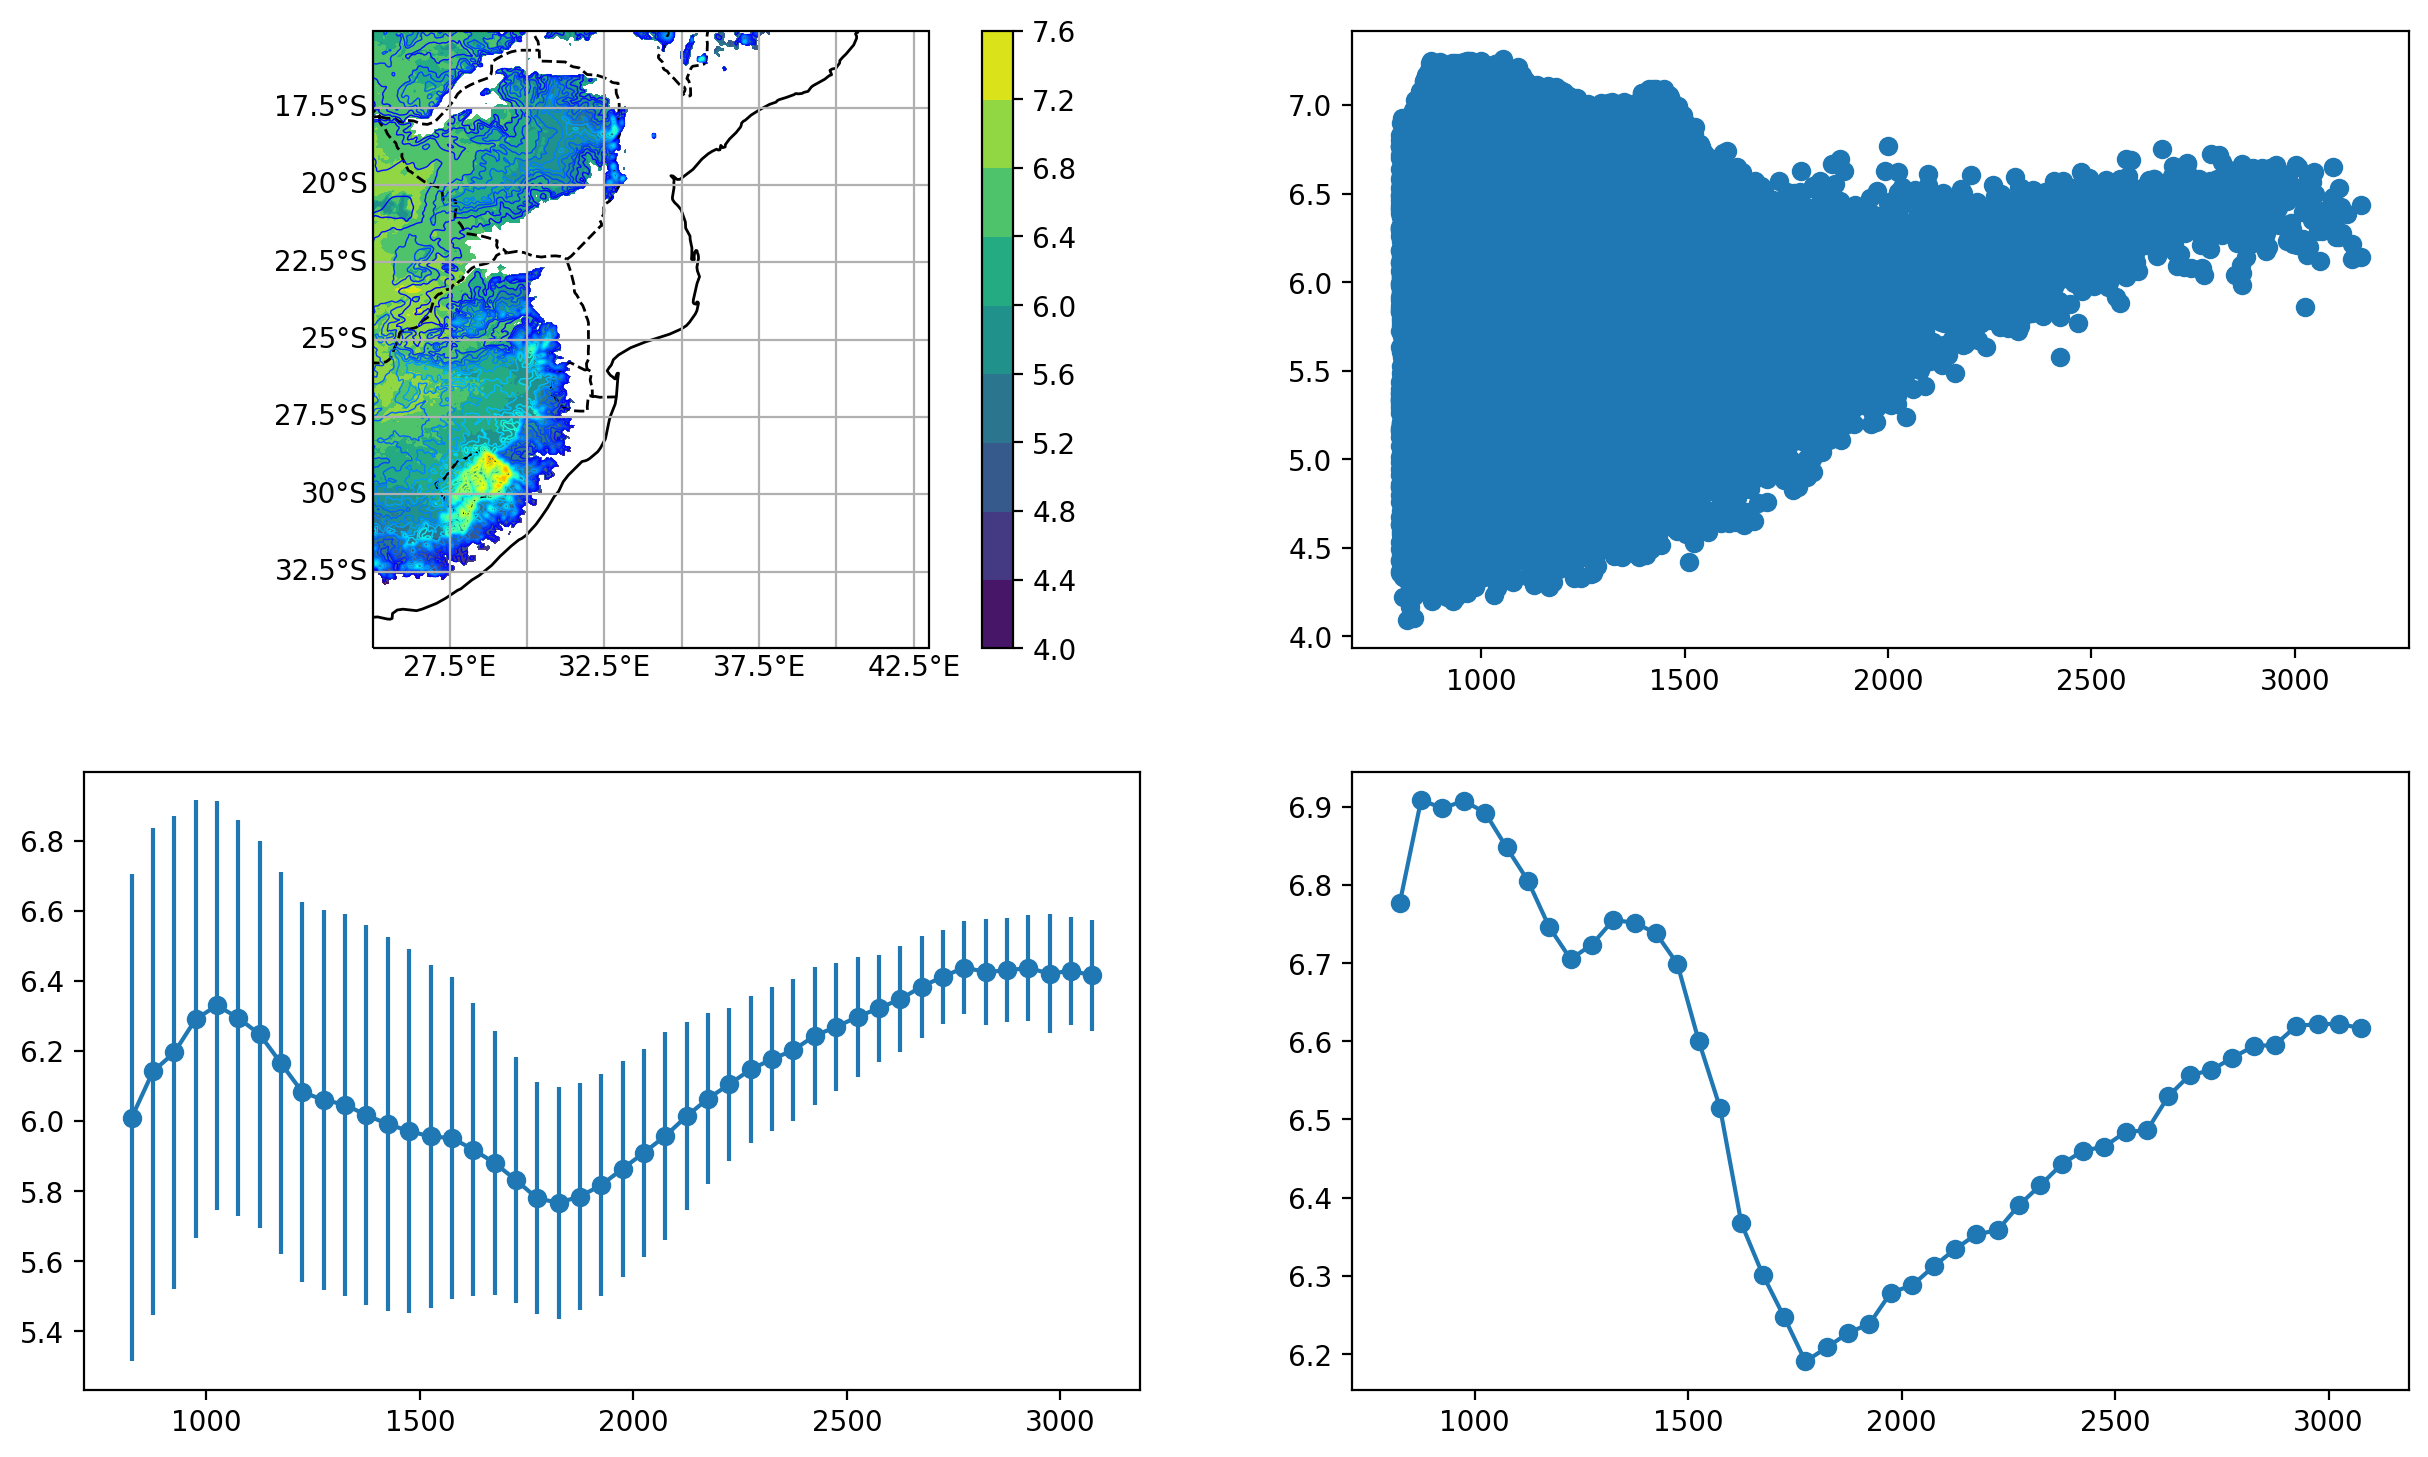

In [67]:
#tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(0,35), longitude=slice(-17,45))

northern = [-17,45,4,14]
southern = [25,43,-35,-15]
alls = [-17,45,-35,37]
h = 800

box = southern

tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_diff.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = xr.open_dataarray('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km_REGRIDDED.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = new_topo.where(new_topo>800)
tdiff = tdiff.where(new_topo>800)


f = plt.figure(figsize=(15,9), dpi=200)


ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
t=new_topo
tt=tdiff['t2_daily']
mapp = ax.contourf(t.longitude, t.latitude, tt, transform=ccrs.PlateCarree())
plt.colorbar(mapp)
mapp = ax.contour(t.longitude, t.latitude, t, transform=ccrs.PlateCarree(), levels=np.arange(500,4200,100), linewidths=0.5, cmap='jet')
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
ax = f.add_subplot(2,2,2)

tnonan = tt.values.flatten()
tnonan = tnonan[np.isfinite(tnonan)]

toponan = t.values.flatten()
toponan = toponan[np.isfinite(toponan)]

ax.scatter(toponan,tnonan)

ax = f.add_subplot(2,2,3)

outdic = var2_binning_mean(toponan, tnonan, np.arange(800,4200,50))
outdicp = var2_binning_perc(toponan, tnonan, np.arange(800,4200,50))

ispos = np.where(np.array(outdic['ycount']) < 50)
print(outdic['ycount'])
y = np.array(outdic['y'])
y[ispos] = np.nan
ax.errorbar(outdic['xbins'],y, yerr=outdic['ystd'], linestyle=None, marker='o')


ax = f.add_subplot(2,2,4)
ispos = np.where(np.array(outdicp['ycount']) < 50)
y = np.array(outdicp['y'])
y[ispos] = np.nan
plt.errorbar(outdicp['xbins'],y, yerr=0, linestyle=None, marker='o')

#f.savefig('/home/ck/DIR/cornkle/figs/EDW/southern_hemisphere.jpg')

[38119, 57306, 71053, 64360, 57174, 47246, 41498, 36703, 30191, 25540, 21491, 17501, 15368, 13962, 12748, 11503, 10408, 9294, 8717, 8504, 8169, 7753, 7133, 6402, 5919, 5468, 4999, 4610, 4153, 3777, 3452, 3111, 2881, 2613, 2367, 2249, 1951, 1691, 1452, 1164, 980, 819, 692, 572, 476, 409, 349, 306, 287, 238, 206, 177, 141, 125, 102, 91, 83, 72, 63, 51, 34, 25, 21, 17, 14, 14, 10]


<ErrorbarContainer object of 3 artists>

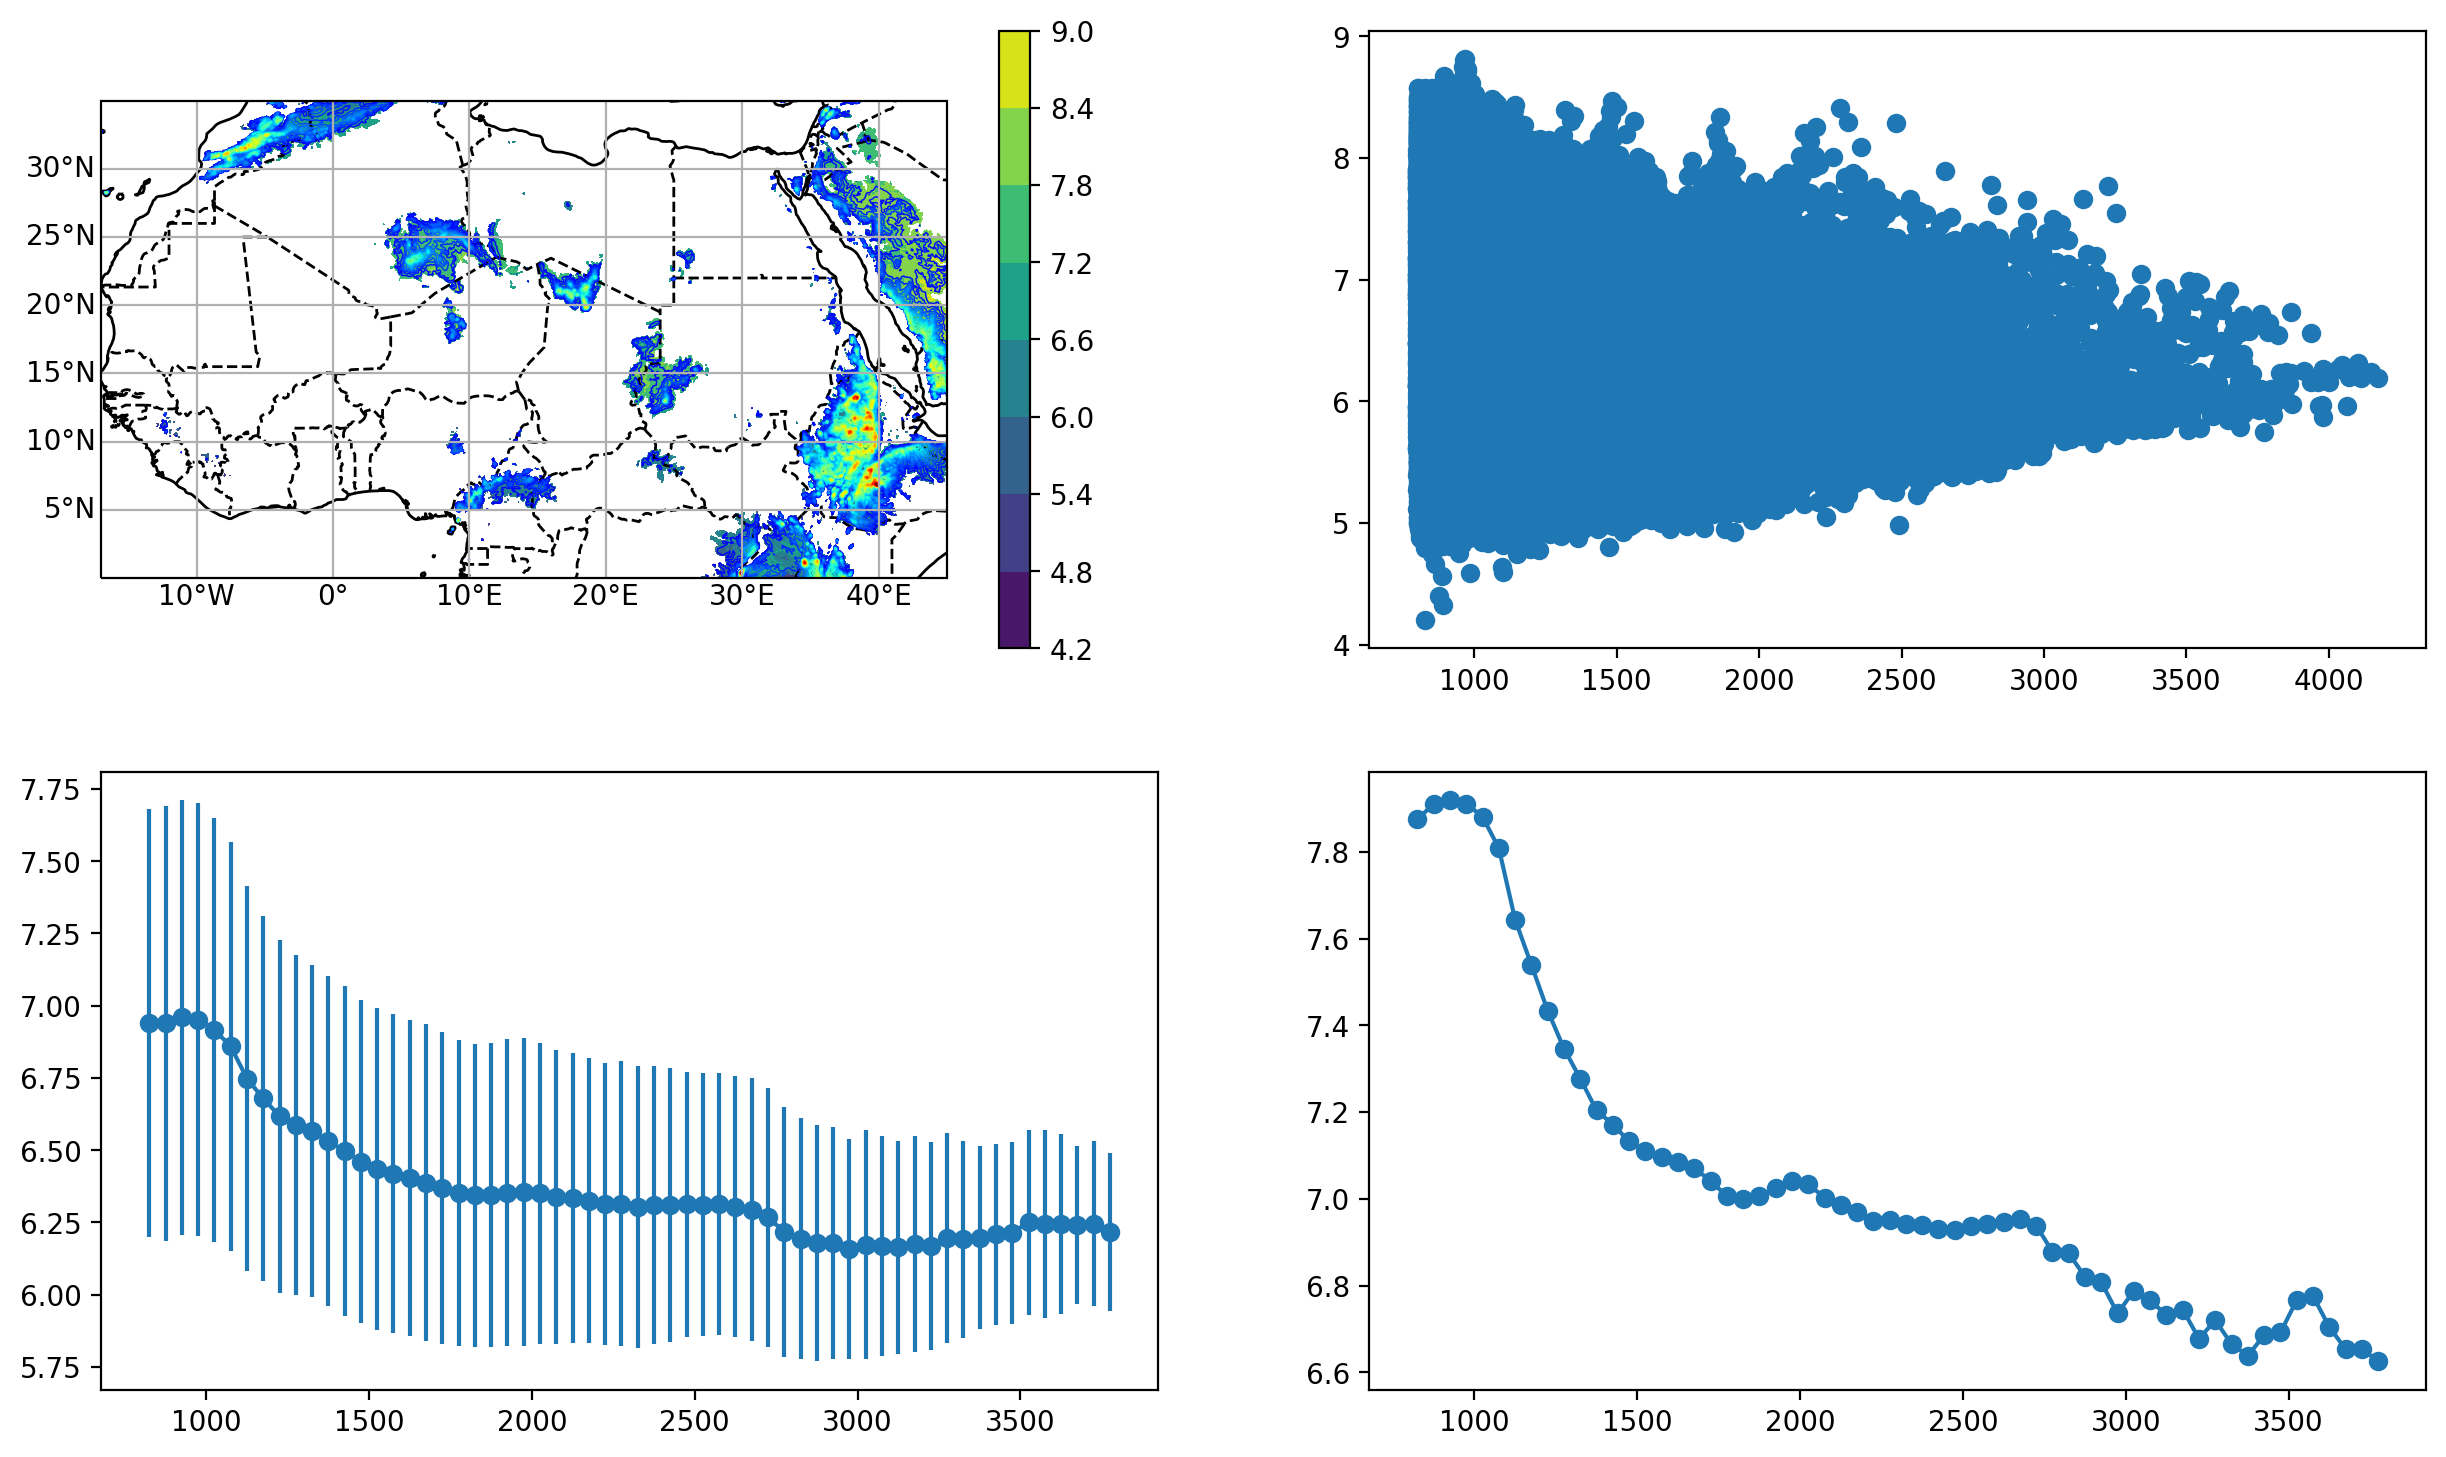

In [68]:
#tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(0,35), longitude=slice(-17,45))

northern = [-17,45,0,35]
southern = [-17,45,-35,0]
alls = [-17,45,-35,37]
h = 800

box = northern

tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_diff.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = xr.open_dataarray('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km_REGRIDDED.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = new_topo.where(new_topo>800)
tdiff = tdiff.where(new_topo>800)


f = plt.figure(figsize=(15,9), dpi=200)


ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
t=new_topo
tt=tdiff['t2_daily']
mapp = ax.contourf(t.longitude, t.latitude, tt, transform=ccrs.PlateCarree())
plt.colorbar(mapp)
mapp = ax.contour(t.longitude, t.latitude, t, transform=ccrs.PlateCarree(), levels=np.arange(500,4200,100), linewidths=0.5, cmap='jet')
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
ax = f.add_subplot(2,2,2)

tnonan = tt.values.flatten()
tnonan = tnonan[np.isfinite(tnonan)]

toponan = t.values.flatten()
toponan = toponan[np.isfinite(toponan)]

ax.scatter(toponan,tnonan)

ax = f.add_subplot(2,2,3)

outdic = var2_binning_mean(toponan, tnonan, np.arange(800,4200,50))
outdicp = var2_binning_perc(toponan, tnonan, np.arange(800,4200,50))

ispos = np.where(np.array(outdic['ycount']) < 50)
print(outdic['ycount'])
y = np.array(outdic['y'])
y[ispos] = np.nan
ax.errorbar(outdic['xbins'],y, yerr=outdic['ystd'], linestyle=None, marker='o')


ax = f.add_subplot(2,2,4)
ispos = np.where(np.array(outdicp['ycount']) < 50)
y = np.array(outdicp['y'])
y[ispos] = np.nan
plt.errorbar(outdicp['xbins'],y, yerr=0, linestyle=None, marker='o')

#f.savefig('/home/ck/DIR/cornkle/figs/EDW/southern_hemisphere.jpg')

[23851, 44196, 65774, 79896, 96383, 107902, 114121, 113803, 101551, 84630, 69635, 56305, 48090, 40882, 33554, 27006, 21200, 15853, 12115, 8986, 6274, 4525, 3363, 2546, 2166, 1956, 1698, 1446, 1215, 1032, 919, 864, 841, 755, 725, 652, 561, 529, 459, 404, 356, 272, 209, 175, 134, 110, 78, 52, 36, 20, 20, 23, 22, 21, 20, 17, 14, 12, 7, 5, 6, 7, 7, 9, 11, 10, 8]


<ErrorbarContainer object of 3 artists>

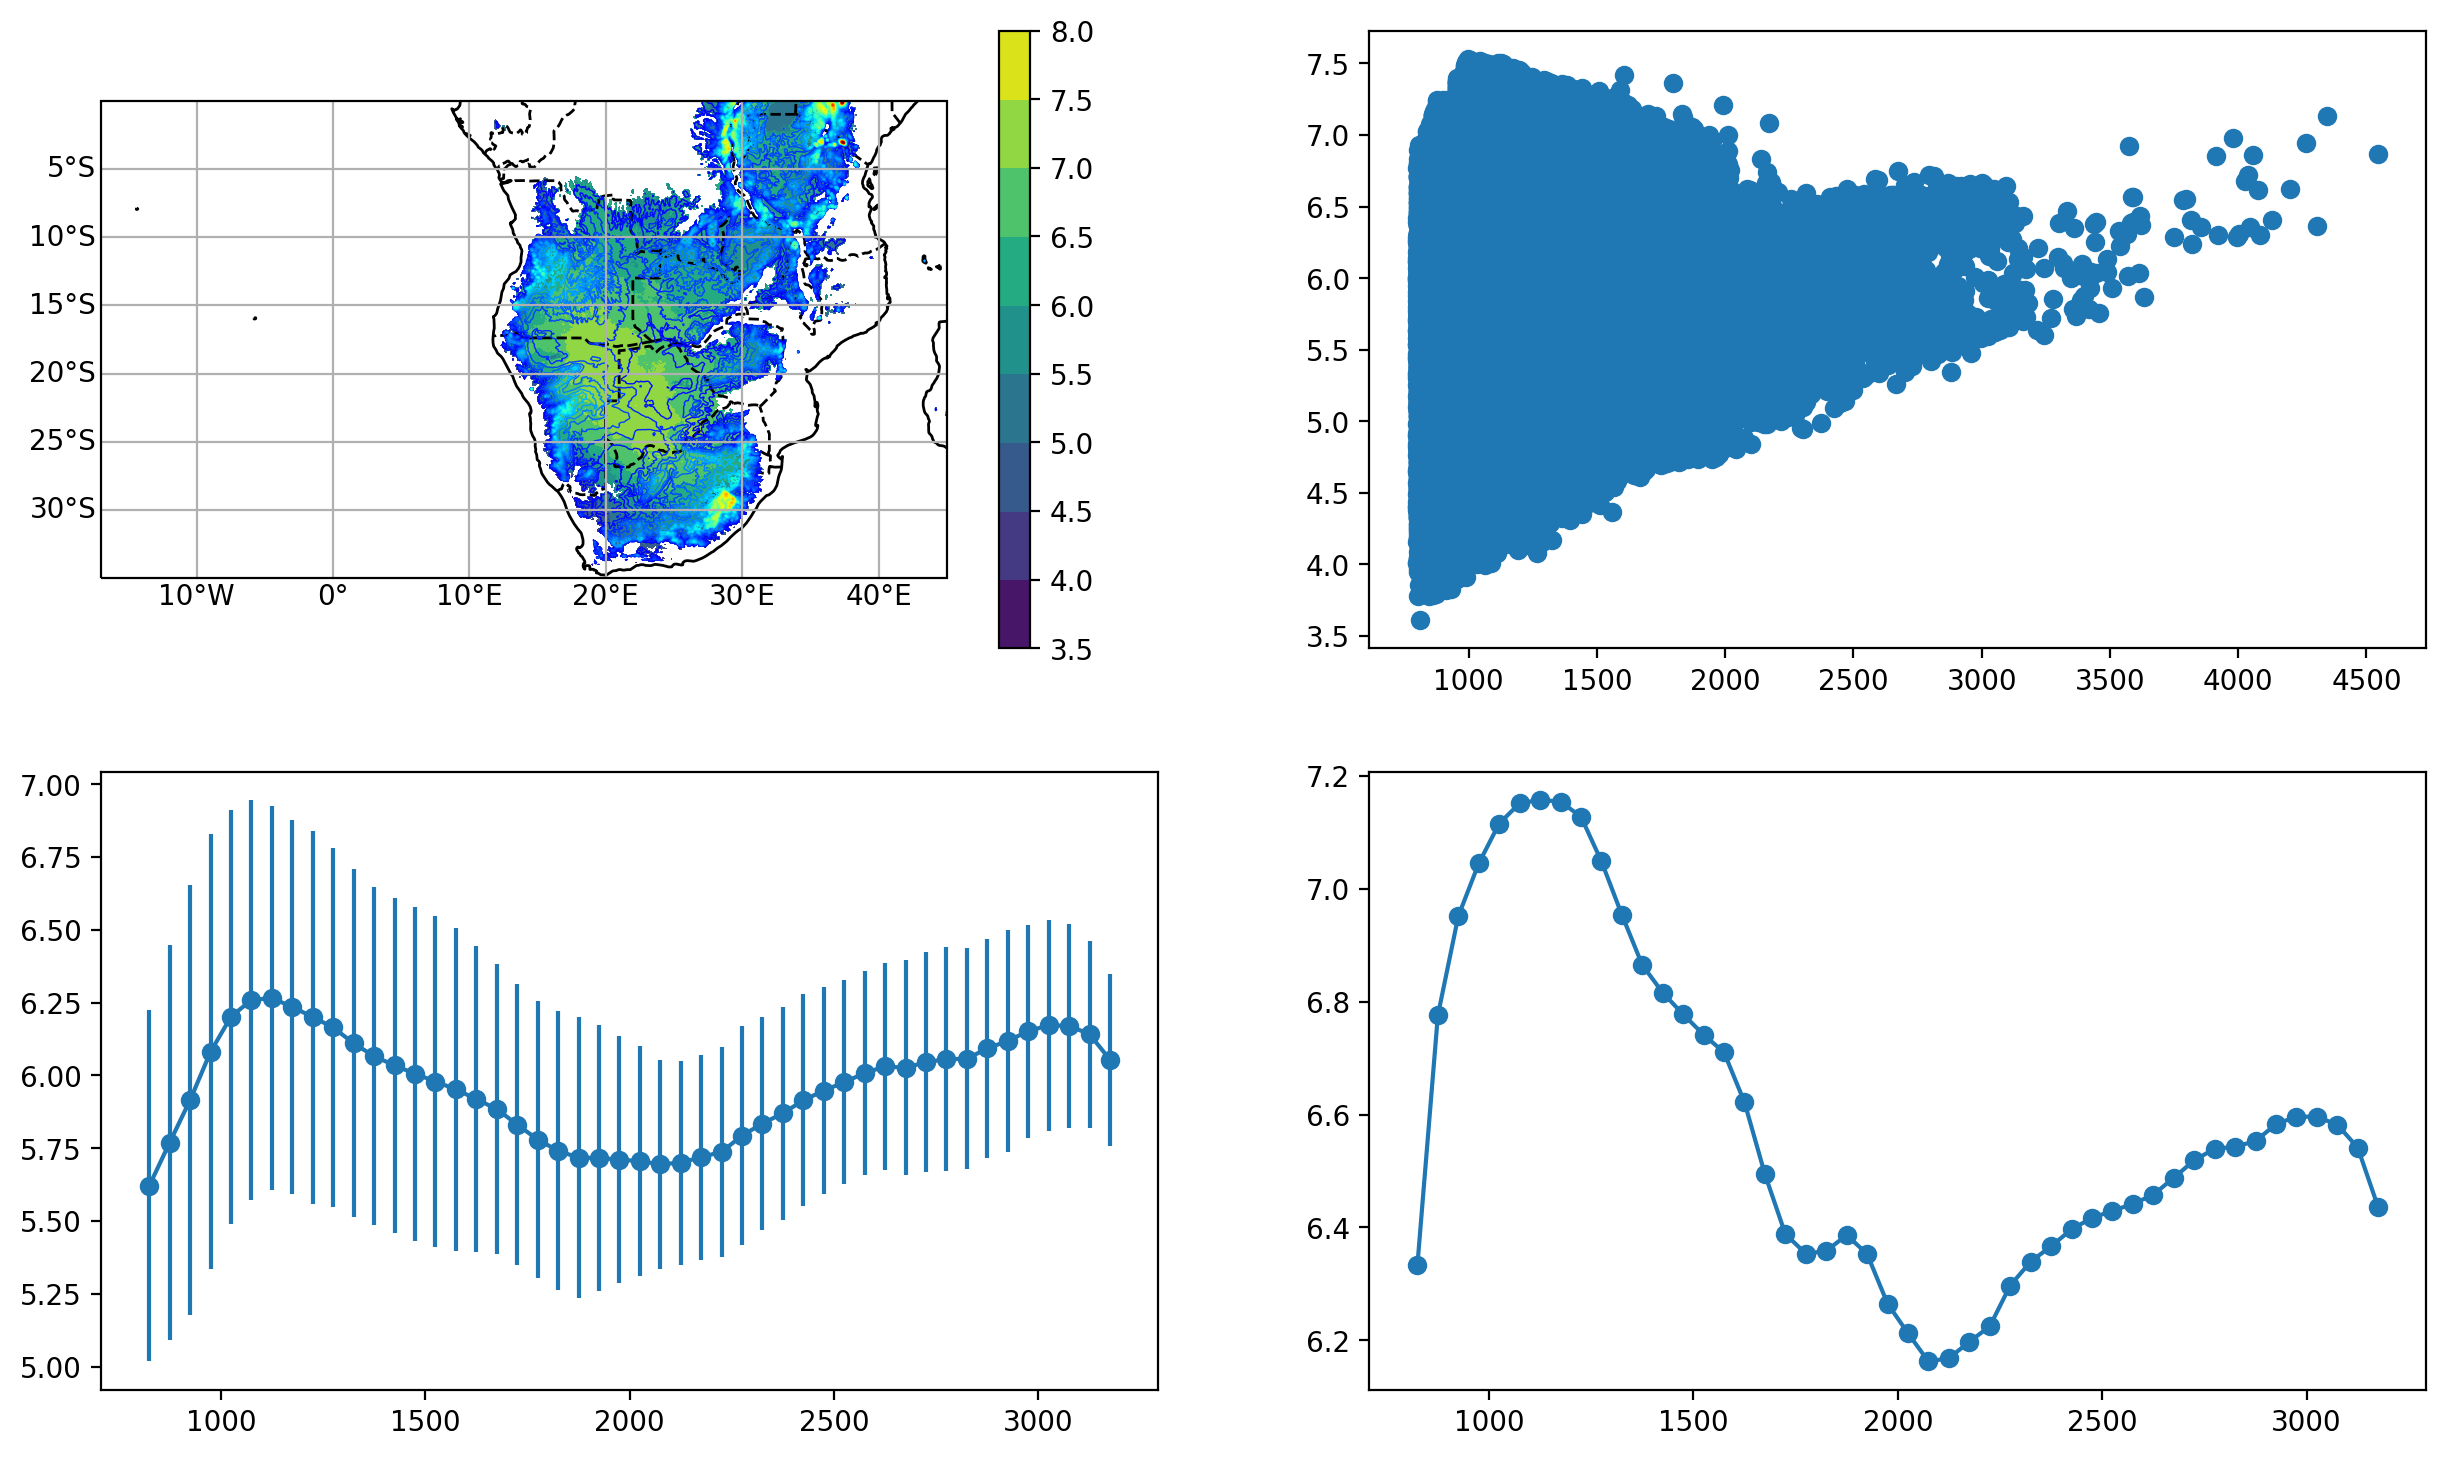

In [72]:
#tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_daily_fullPL__Aday_max_ac144_4km_mean.nc').sel(latitude=slice(0,35), longitude=slice(-17,45))

northern = [-17,45,0,35]
southern = [-17,45,-35,0]
alls = [-17,45,-35,37]
h = 800

box = southern

tdiff = xr.open_dataset('/home/ck/DIR/cornkle/data/EDW/EDW_files/t2_diff.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = xr.open_dataarray('/home/ck/DIR/cornkle/data/EDW/EDW_files/orog_original_ac144_ancil_4km_REGRIDDED.nc').sel(latitude=slice(box[2],box[3]), longitude=slice(box[0],box[1]))
new_topo = new_topo.where(new_topo>800)
tdiff = tdiff.where(new_topo>800)


f = plt.figure(figsize=(15,9), dpi=200)


ax = f.add_subplot(2,2,1, projection=ccrs.PlateCarree())
t=new_topo
tt=tdiff['t2_daily']
mapp = ax.contourf(t.longitude, t.latitude, tt, transform=ccrs.PlateCarree())
plt.colorbar(mapp)
mapp = ax.contour(t.longitude, t.latitude, t, transform=ccrs.PlateCarree(), levels=np.arange(500,4200,100), linewidths=0.5, cmap='jet')
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
ax = f.add_subplot(2,2,2)

tnonan = tt.values.flatten()
tnonan = tnonan[np.isfinite(tnonan)]

toponan = t.values.flatten()
toponan = toponan[np.isfinite(toponan)]

ax.scatter(toponan,tnonan)

ax = f.add_subplot(2,2,3)

outdic = var2_binning_mean(toponan, tnonan, np.arange(800,4200,50))
outdicp = var2_binning_perc(toponan, tnonan, np.arange(800,4200,50))

ispos = np.where(np.array(outdic['ycount']) < 50)
print(outdic['ycount'])
y = np.array(outdic['y'])
y[ispos] = np.nan
ax.errorbar(outdic['xbins'],y, yerr=outdic['ystd'], linestyle=None, marker='o')


ax = f.add_subplot(2,2,4)
ispos = np.where(np.array(outdicp['ycount']) < 50)
y = np.array(outdicp['y'])
y[ispos] = np.nan
plt.errorbar(outdicp['xbins'],y, yerr=0, linestyle=None, marker='o')

#f.savefig('/home/ck/DIR/cornkle/figs/EDW/southern_hemisphere.jpg')